In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_source/mb_source.npy'
target_img_path = head / 'data/mb_noisy/mb_noisy.npy'
source_meta = head / 'data/mb_source/mb_source_metadata.csv'
target_meta = head / 'data/mb_noisy/mb_noisy_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

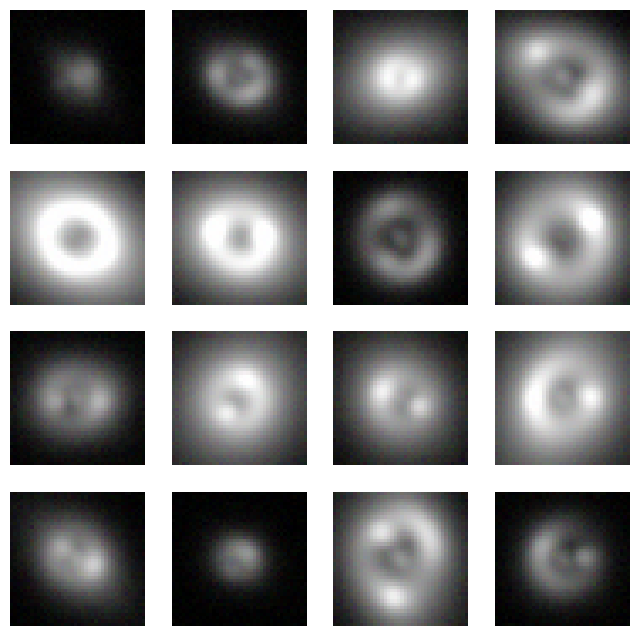

In [3]:
# Visualize source data
visualize_data(source_data)

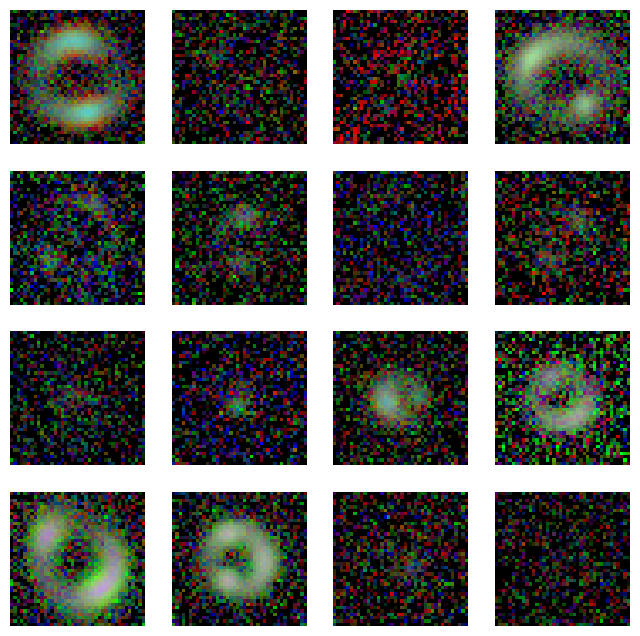

In [4]:
# Visualize target data
visualize_data(target_data)

In [7]:
model = NeuralNetwork().cuda()
learning_rate = 3e-5
epochs = 50
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [8]:
mod_name = "models/mb_isomap_jul22_2153"
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...
(2000, 4800)


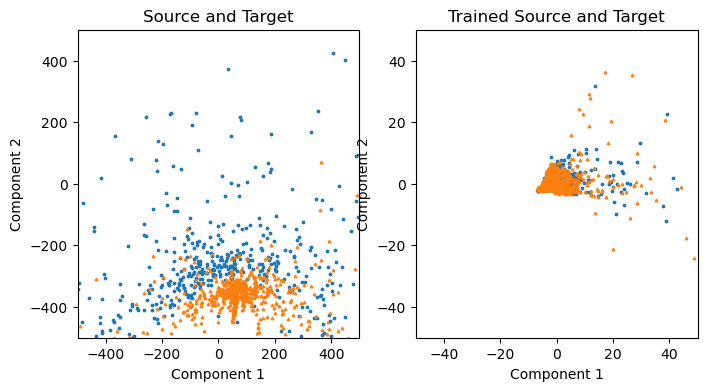

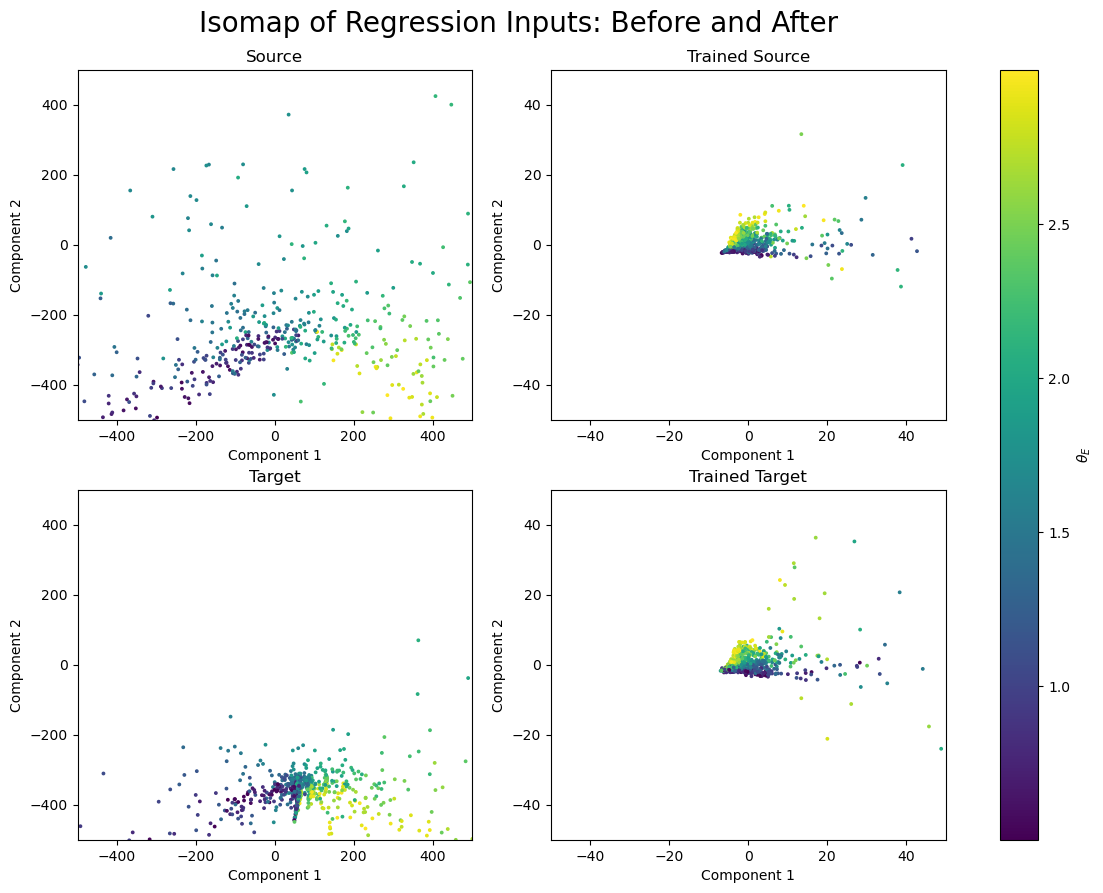


Epoch 50: 31.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0411
	Train Regression Loss: : 0.0115
	Train R2 Score: : 0.9767
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.0995
	Val Source R2 Score: : 0.9746
	Val Target R2 Score: : 0.8046

Epoch 51: 25.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0388
	Train Regression Loss: : 0.0118
	Train R2 Score: : 0.9760
 Validation Statistics:
	Val Source Regression Loss: : 0.0122
	Val Target Regression Loss: : 0.0994
	Val Source R2 Score: : 0.9723
	Val Target R2 Score: : 0.8067

Epoch 52: 21.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0361
	Train Regression Loss: : 0.0117
	Train R2 Score: : 0.9762
 Validation Statistics:
	Val Source Regression Loss: : 0.0107
	Val Target Regression Loss: : 0.0965
	Val Source R2 Score: : 0.9774
	Val Target R2 Score: : 0.8107

Epoch 53: 20.38s
----------------------------

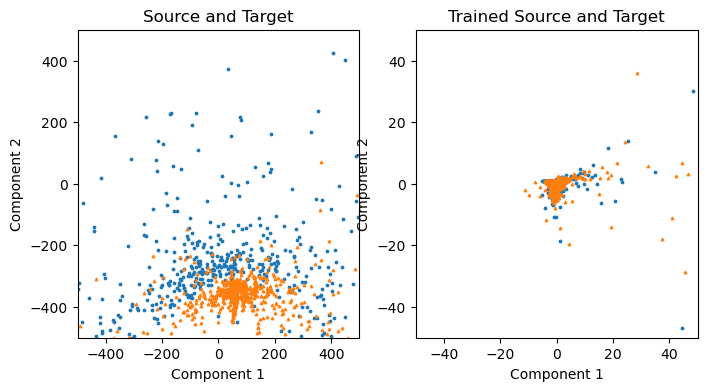

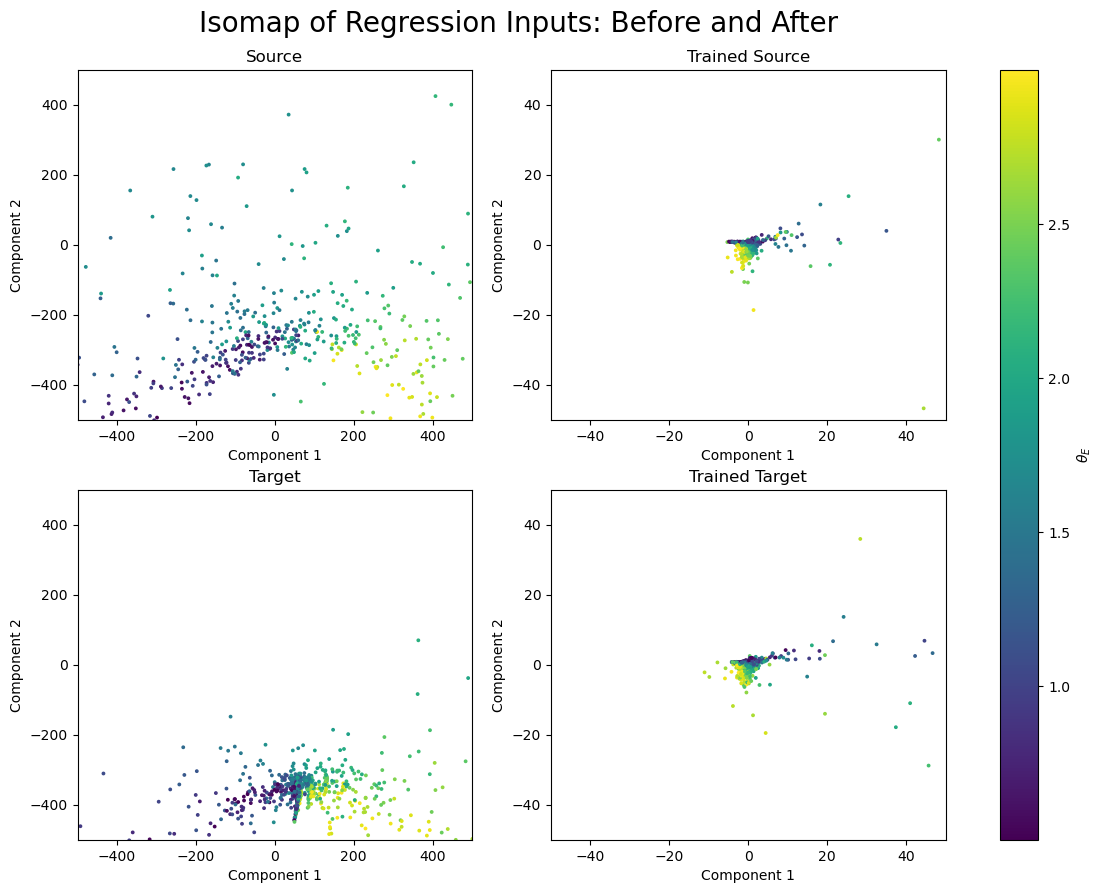


Epoch 55: 28.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0312
	Train Regression Loss: : 0.0109
	Train R2 Score: : 0.9778
 Validation Statistics:
	Val Source Regression Loss: : 0.0104
	Val Target Regression Loss: : 0.1017
	Val Source R2 Score: : 0.9785
	Val Target R2 Score: : 0.7995

Epoch 56: 25.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0302
	Train Regression Loss: : 0.0108
	Train R2 Score: : 0.9780
 Validation Statistics:
	Val Source Regression Loss: : 0.0104
	Val Target Regression Loss: : 0.0977
	Val Source R2 Score: : 0.9783
	Val Target R2 Score: : 0.8078

Epoch 57: 23.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0286
	Train Regression Loss: : 0.0105
	Train R2 Score: : 0.9787
 Validation Statistics:
	Val Source Regression Loss: : 0.0102
	Val Target Regression Loss: : 0.0999
	Val Source R2 Score: : 0.9789
	Val Target R2 Score: : 0.8038

Epoch 58: 20.17s
----------------------------

KeyboardInterrupt: 

In [9]:
print("Beginning Training...")
mod_name = "models/mb_isomap_jul22_2153"
# Train
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 500, 50, save = True)
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['epoch_no'] += 1
        print_epoch_scores(stats, i, time.time() - start_time)

In [ ]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

mod_name = mod_name = "models/mb_isomap_jul22_2153_100ep"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [10]:
#mod_name = "models/mb_isomap_jul18_6pm"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

In [21]:
def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [10]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

(2000, 4800)


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [11]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

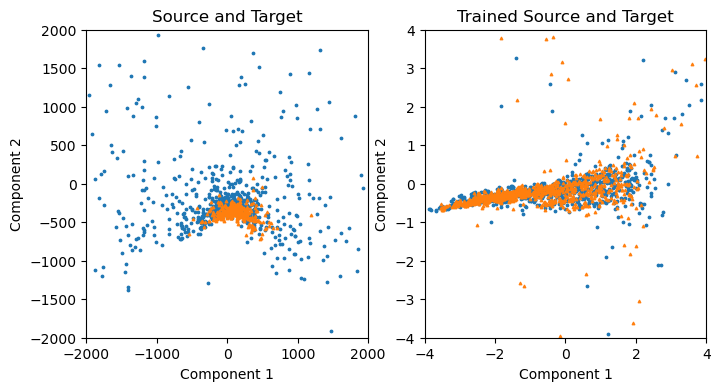

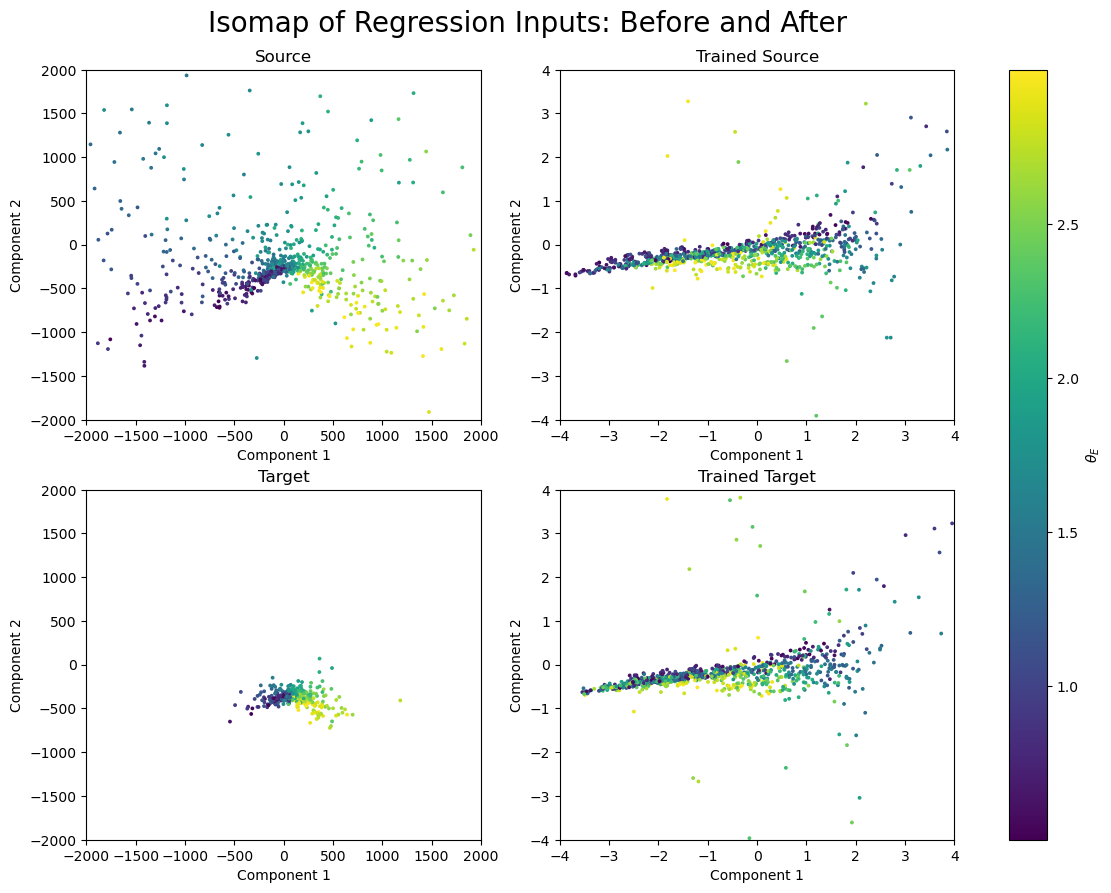

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [13]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 2000, 4)

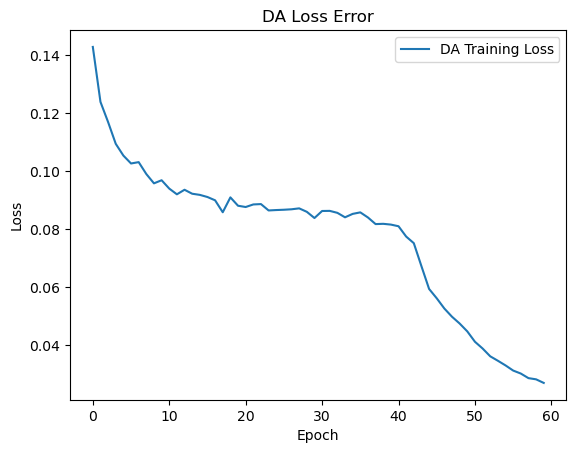

In [14]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

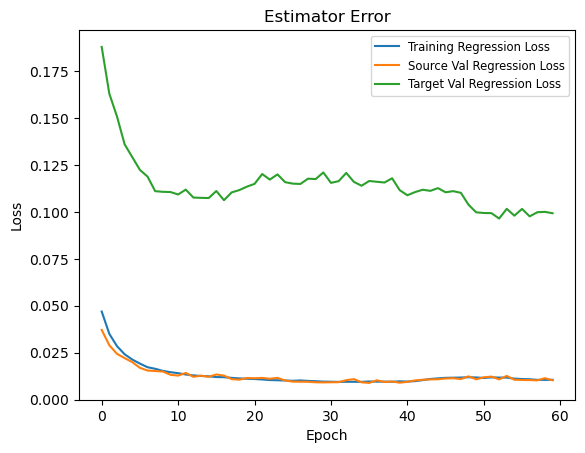

In [15]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

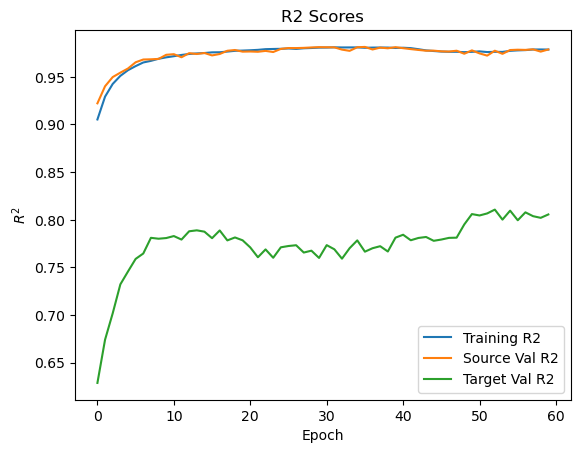

In [16]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.9790


Text(0.5, 1.0, 'MMD | Source | R2: 0.979')

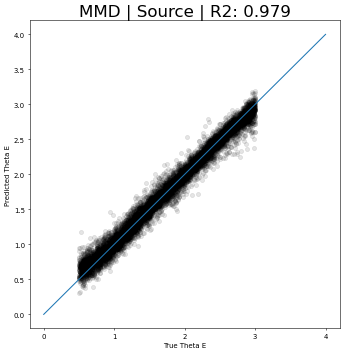

In [17]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.7960


Text(0.5, 1.0, 'MMD | Target | R2: 0.796')

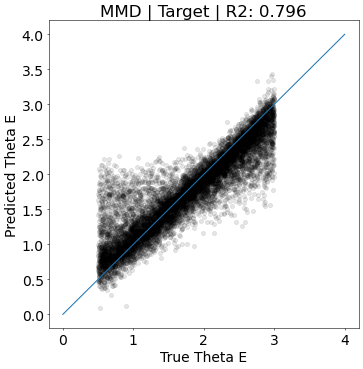

In [18]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))